In [42]:
# Implementation of the Rogers and Veraart 2013 Debt Model with Default Costs in Python.
# In their 2013 paper - Failure and Rescue in an Interbank Network - Rogers and Veraart extend the Eisenberg and 
# Noe 2001 Debt Model (which analyses the properties of intercorporate cash flows in financial systems featuring 
# cyclical interdependence and endogenously determined clearing vectors). The model computes clearing vectors for 
# interlinked financial systems (systemic risk in an interbank market modelled as a directed graph of interbank 
# obligations wuih the costs of default if a failing bank recalls loans/obligations). A clearing vector is a 
# vector of payments from nodes in the financial system to other nodes and  must satisfy the conditions of 
# proportional repayments of liabilities in default (we assume  all debt claims have equal priority i.e. all 
# claimant nodes are paid by the defaulting node in proportion to 
# the size of their nominal claim on firm assets), limited liability of equity (which requires that the total 
# payments made by a node must never exceed the cash flow available to the node;) and absolute priority of debt 
# over equity. The clearing vector is computed through a "fictitious sequential default" algorithm in which the 
# set of defaulting firms at the start of each round is fixed by the dynamic adjustments of the system from the 
# preceding round. At the beginning, when calculating cash on hand for each firm, assume that each firm receives 
# what it expects to receive from its debtors then calculate what each firm needs to pay out (i.e. the min of 
# cash on hand vs nominal obligation) and update the total dollar payment vector. In each new round, an attempt 
# to clear the system that assumes that only nodes that defaulted in the previous round default. If no new 
# defaults occur, the algorithm terminates (i.e. a node is a distinct economic entity or a financial node i.e. a 
# firm) and we have the greatest clearing vector. Also, due to the presence of default losses, there is an 
# incentive for solvent banks to form consortia and rescue failing banks.

# This algorithm gives the clearing vector and a natural measure of systemic risk (i.e. the exposure of a given 
# node in the system to defaults by other firms - this is based on the number of waves of defaults required to 
# induce a given firm in the system to fail)

# Scenario 1 - Initialisation with 3 nodes, no firm defaults during first round and algorithm terminates    
# MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,1],[3,0,1],[2,5,0]]), 
# OPERATING_CASH_FLOW_VECTOR = [5, 4, 5], implicitly ALPHA=BETA=1

# Scenario 2 - Initialisation with 3 nodes, firm C defaults during first round and no secondary defaults, algorithm terminates round 2    
# MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,1],[3,0,1],[2,5,0]]), 
# OPERATING_CASH_FLOW_VECTOR = [5, 4, 2], implicitly ALPHA=BETA=1

# Scenario 3 - Firm B defaults in first round, Firm A in second round, algorithm terminates round 3  
# MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,9],[7,0,9],[3,1,0]]),
# OPERATING_CASH_FLOW_VECTOR = [3, 0, 4], implicitly ALPHA=BETA=1

# Scenario 4 - Firm B defaults in first round, Firm A in second round, algorithm terminates round 3  
# MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,9],[7,0,9],[3,1,0]]),
# OPERATING_CASH_FLOW_VECTOR = [3, 0, 4], ALPHA=BETA=0.5

# Scenario 5 - Firm B defaults in first round, Firm A in second round, algorithm terminates round 3  
# MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,9],[7,0,9],[3,1,0]]),
# OPERATING_CASH_FLOW_VECTOR = [3, 0, 4], ALPHA=0.1, BETA=0.9

# Scenario 6 - Random Initialisation with 3 nodes    
# MODE == 'RANDOM', NUM_AGENTS = 3, implicitly ALPHA=BETA=1

# Scenario 7 - Random Initialisation with 3 nodes    
# MODE == 'RANDOM', NUM_AGENTS = 3, ALPHA=BETA=0.5

# Scenario 8 - Random Initialisation with 3 nodes    
# MODE == 'RANDOM', NUM_AGENTS = 3, ALPHA=0.1, BETA=0.9

# Scenario 9 - Random Initialisation with 5 nodes    
# MODE == 'RANDOM', NUM_AGENTS = 5, implicitly ALPHA=BETA=1

# to export output without code, run the following from your terminal
# jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True  eisenberg-noe-2001-debt-model-with-default-costs.ipynb

# Julian Kanjere, knjjul001@myuct.ac.za, November 2021

######### IMPORTS ######### 

import numpy as np
import pandas as pd
import random
import sys

######### /IMPORTS ######### 

######### MODEL SETUP ######### 
# MODE is either MANUAL or RANDOM
MODE = 'MANUAL'  # Scenario 1, 2, 3, 4 & 5
# MODE = 'RANDOM'  # Scenario 6,7, 8, & 9

ALPHABET ='ABCDEFGHIJKLMNOPQRSTUVWXYZ' # we label nodes A, B, C etc

# a dictionary whose key is the round starting from 1 and value is a list of exogenous cash infusion to a 
# node i.e. from outside sources. This is referred to as net assets (e) by Rogers and Veraat
OPERATING_CASH_FLOW_VECTOR = []

# ALPHA and BETA are the fraction of exogenous assets (outside financial network) and endogenous assets 
# (inside financial network i.e. interbank obligations) that are realised on liquidation in the event of default.
# The two fractions may conceivably be different; we would typically expect that ALPHA would be low, 
# because the bank would be having to sell off its loan portfolio, probably at a knock-down price/fire sale. 
# A fire sale consists of selling goods or assets at heavily discounted prices. "Fire sale" originally referred 
# to the discount sale of goods that were damaged by fire. Now it more commonly refers to any sale where the 
# seller is in financial distress.
# In contrast, BETA might be much closer to 1, because an obligation from a solvent bank would probably be paid 
# in full (though perhaps with some negotiated discount to compensate for the inconvenience of early repayment) 
# SCENARIO 1, 2, 3, 6, 9 - No default losses
ALPHA = 1 # 0 < ALPHA <= 1 i.e. ALPHA = (0,1], ALPHA is closer to 0 
BETA = 1 # 0 < BETA <= 1 i.e. BETA = (0,1], BETA is closer to 1

# SCENARIO 4, 7 
# ALPHA = 0.5 # 0 < ALPHA <= 1 i.e. ALPHA = (0,1], ALPHA is closer to 0 
# BETA = 0.5 # 0 < BETA <= 1 i.e. BETA = (0,1], BETA is closer to 1

# SCENARIO 5, 8
# ALPHA = 0.1 # 0 < ALPHA <= 1 i.e. ALPHA = (0,1], ALPHA is closer to 0 
# BETA = 0.9 # 0 < BETA <= 1 i.e. BETA = (0,1], BETA is closer to 1

print("\n--------------------------------------------------------\n")
print("DEBT MODEL WITH DEFAULT COSTS \n")

print("ALPHA = %s and BETA = %s" % (str(ALPHA), str(BETA)))

if MODE == 'MANUAL':
    NUM_AGENTS = 3 # Scenario 1, 2, 3, 4, 5, 
    
    MATRIX_SIZE = NUM_AGENTS * NUM_AGENTS # e.g. 3 x 3

    print("Running Debt Model in %s mode with %s nodes..." % (MODE, NUM_AGENTS))
    
    # SCENARIO = "\nScenario 1 - Initialisation with 3 nodes, no firm defaults during first round and algorithm terminates, MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,1],[3,0,1],[2,5,0]]), OPERATING_CASH_FLOW_VECTOR = [5, 4, 5], and implicitly ALPHA=BETA=1)"
    # SCENARIO = "\nScenario 2 - Initialisation with 3 nodes, firm C defaults during first round and no secondary defaults, algorithm terminates round 2, MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,1],[3,0,1],[2,5,0]]), OPERATING_CASH_FLOW_VECTOR = [5, 4, 2], and implicitly ALPHA=BETA=1"
    SCENARIO = "\nScenario 3 - Firm B defaults in first round, Firm A in second round, algorithm terminates round 3, MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,9],[7,0,9],[3,1,0]]), OPERATING_CASH_FLOW_VECTOR = [3, 0, 4], and implicitly ALPHA=BETA=1"
    # SCENARIO = "\nScenario 4 - Firm B defaults in first round, Firm A in second round, algorithm terminates round 3, MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,9],[7,0,9],[3,1,0]]), OPERATING_CASH_FLOW_VECTOR = [3, 0, 4], ALPHA = 0.5, BETA = 0.5"
    # SCENARIO = "\nScenario 5 - Firm B defaults in first round, Firm A in second round, algorithm terminates round 3, MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,9],[7,0,9],[3,1,0]]), OPERATING_CASH_FLOW_VECTOR = [3, 0, 4], ALPHA = 0.1, BETA = 0.9"

    print(SCENARIO)
    
    # n x n nominal liabilities matrix L captures the nominal liability of one node to another in the system
    # i.e. L_ij is nominal liability of node i to node j. All nominal claims are nonnegative (i.e. L_ij > 0) and a
    # Fix nominal liabilities and observe that a node cannot have liabilities against itself hence AA, BB and CC are 0
    # i.e. AA=0, AB=2, AC=1, BA=3 and so forth...
    # NOMINAL_LIABILITY_MATRIX = np.array([[0,2,1],[3,0,1],[2,5,0]]) # Scenario 1
    # NOMINAL_LIABILITY_MATRIX = np.array([[0,2,1],[3,0,1],[2,5,0]]) # Scenario 2 
    NOMINAL_LIABILITY_MATRIX = np.array([[0,2,9],[7,0,9],[3,1,0]]) # Scenario 3, 4 & 5
    
    # Fix i.e. hardcode exogenous operating cashflow vector. The number of elements should match number of agents.
    # OPERATING_CASH_FLOW_VECTOR = [5, 4, 5] # Scenario 1
    # OPERATING_CASH_FLOW_VECTOR = [5, 4, 2] # Scenario 2
    OPERATING_CASH_FLOW_VECTOR = [3, 0, 4] # Scenario 3, 4 & 5
    # OPERATING_CASH_FLOW_VECTOR = [3, 0, 4] # Scenario 6, 7, 8, 9
else:    
    # if mode is RANDOM
    # i.e. n x n assuming a star network with each node connected to the other i.e. cyclical interdependence
    #NUM_AGENTS = 3 # Scenario 6, 7, 8
    NUM_AGENTS = 5 # Scenario 9
    
    MATRIX_SIZE = NUM_AGENTS * NUM_AGENTS # e.g. 3 x 3

    print("Running Debt Model in RANDOM mode with %s nodes..." % (NUM_AGENTS))
        
    # SCENARIO = "\nScenario 6 - Random Initialisation with 3 nodes, MODE == 'RANDOM', NUM_AGENTS = 3 and implicitly ALPHA=BETA=1"
    # SCENARIO = "\nScenario 7 - Random Initialisation with 3 nodes, MODE == 'RANDOM', NUM_AGENTS = 3, ALPHA = BETA = 0.5"
    # SCENARIO = "\nScenario 8 - Random Initialisation with 3 nodes, MODE == 'RANDOM', NUM_AGENTS = 3, ALPHA = 0.1, BETA = 0.9"
    SCENARIO = "\nScenario 9 - Random Initialisation with 5 nodes, MODE == 'RANDOM', NUM_AGENTS = 5, and implicitly ALPHA=BETA=1"
    
    print(SCENARIO)
          
    # Nominal liability ranges used when randomly initialising the NOMINAL_LIABILITY_MATRIX
    NOMINAL_LIABILITY_LOWER_RANGE = 1 # this should preferably be > 0 or else you can run into division by zero errors
    NOMINAL_LIABILITY_UPPER_RANGE = 10

    # Randomly generate nominal liability matrix. Denoted as L by Rogers and Veraart
    NOMINAL_LIABILITY_MATRIX = np.random.randint(NOMINAL_LIABILITY_LOWER_RANGE, NOMINAL_LIABILITY_UPPER_RANGE, 
                                                 size=MATRIX_SIZE).reshape(NUM_AGENTS, NUM_AGENTS)
    np.fill_diagonal(NOMINAL_LIABILITY_MATRIX, 0) # a node cannot have liabilities against itself
    
    # Exogenous cashflow ranges used when randomly initialising the OPERATING_CASH_FLOW_VECTOR
    EXOGENOUS_CASHFLOW_LOWER_RANGE = 0
    EXOGENOUS_CASHFLOW_UPPER_RANGE = 10
    
    # Randomly generate exogenous operating cashflow vector
    for row in range (0, NUM_AGENTS):
        exogenous_cash_flow = random.randint(EXOGENOUS_CASHFLOW_LOWER_RANGE, EXOGENOUS_CASHFLOW_UPPER_RANGE)
        OPERATING_CASH_FLOW_VECTOR.append(exogenous_cash_flow)
    
AGENT_LABELS = [ALPHABET[i] for i in range(0, NUM_AGENTS)] 
print("\n--------------------------------------------------------\n")
print("AGENT LABELS\n")
print("Agent labels", str(AGENT_LABELS))
print("\n--------------------------------------------------------\n")

NOMINAL_LIABILITY_MATRIX_DF = pd.DataFrame(NOMINAL_LIABILITY_MATRIX, index=AGENT_LABELS, columns=AGENT_LABELS)
print("NOMINAL LIABILITY MATRIX Data Frame")
print("i.e. what node i expects to pay node j...")
display(NOMINAL_LIABILITY_MATRIX_DF)

print("\nNominal liabilities for each node:")
for row in range(0, NUM_AGENTS):
    for column in range(0, NUM_AGENTS):
        if row == column:
            pass
        else:
            print("Liability of Node %s to Node %s is %s" % (AGENT_LABELS[row], AGENT_LABELS[column], 
                                                             NOMINAL_LIABILITY_MATRIX_DF.iloc[row, column]))

# used to show what each agent is receiving, read row wise
print("\nNOMINAL LIABILITY MATRIX TRANSPOSED Data Frame")
print("i.e. what node j expects to receive from i...")                    
NOMINAL_LIABILITY_MATRIX_TRANSPOSED_DF = NOMINAL_LIABILITY_MATRIX_DF.T 

display(NOMINAL_LIABILITY_MATRIX_TRANSPOSED_DF)
for row in range(0, NUM_AGENTS):
    for column in range(0, NUM_AGENTS):
        if row == column:
            pass
        else:
            print("Node %s expects to receive %s from Node %s" % 
                  (AGENT_LABELS[row], NOMINAL_LIABILITY_MATRIX_TRANSPOSED_DF.iloc[row, column],
                  AGENT_LABELS[column]))
    
# n x n relative liabilities matrix which represents the nominal liability of one node to another in the system
# as a proportion of the debtor nodes total liabilites i.e. L_ij / p_i. We first initialise with zeros. 
RELATIVE_LIABILITY_MATRIX = np.zeros((NUM_AGENTS, NUM_AGENTS)) 
RELATIVE_LIABILITY_MATRIX_DF = pd.DataFrame(RELATIVE_LIABILITY_MATRIX, index=AGENT_LABELS, columns=AGENT_LABELS)

# print operating cash flow vector values
print("\n--------------------------------------------------------\n")
print("OPERATING CASH FLOW VECTOR\n")
for row in range (0, NUM_AGENTS):
    print("Exogenous cash flow for Node %s: %s" % (AGENT_LABELS[row], OPERATING_CASH_FLOW_VECTOR[row]))
print(OPERATING_CASH_FLOW_VECTOR)

# TODO - alternative to vectors as a dict of lists is to simply use dataframes?

# a dictionary whose key is the round starting from 0 and value is a list or a set of 
# total payments made by each node to other nodes in the system i.e. p = (p_1, p_2, p_3, ...)
# where p_1 is the total dollar payment by node 1
TOTAL_DOLLAR_PAYMENT_VECTOR = {}

# a list of payments  made by each node to other nodes in the system 
# i.e. p_bar = (p_bar_1, p_bar_2, p_bar_3, ...) where p_bar_1 is the total nominal obligation for node 1
TOTAL_OBLIGATION_VECTOR = []

# a list of payments out by each node
CLEARING_PAYMENT_VECTOR = [] 

# a dictionary whose key is the round starting from 0 and value is a list of defaulters for that round
DEFAULTERS_VECTOR = {} 

# a dictionary whose key is the round starting from 0 and value is a list of each nodes equity for that round
EQUITY_VECTOR = {} 

# Rogers and Veraart refer to the financial system as phi
# phi is a system made up of (NOMINAL_LIABILITY_MATRIX_DF i.e. liabilities matrix [L], 
                            # OPERATING_CASH_FLOW_VECTOR i.e. exogenous cash flow [net assets e], 
                            # ALPHA i.e. proportion of exogenous assets recovered [net assets e]
                            # BETA i.e. proportion of endogenous assets recovered [obligations])
            
# A clearing vector for the financial system phi is:
# EITHER total obligation value for node i if total obligation value for node i (from TOTAL_OBLIGATION_VECTOR) 
# is less than or equal to (node i's exogenous assets) + (payments received from other nodes)
# OR ALPHA*(node i's exogenous assets) + BETA*(payments received from other nodes)

# On default of bank i, there are actual losses of at least 
# (1 - ALPHA)*(node i's exogenous assets) + (1- BETA)*(payments received from other nodes)

# a dictionary whose key is the round starting from 0 and value is a list or a set of actual losses by round 
# (by each node for the specified ALPHA and BETA parameters)  
# i.e. {'round 1' : [loss_node1, loss_node2], 'round 2' : [loss_node1, loss_node2]}
DEFAULT_LOSSES_BY_ROUND_VECTOR = {}

# a list of actual losses (by each node for the specified ALPHA and BETA parameters) 
DEFAULT_LOSSES_VECTOR = [] 

######### /MODEL SETUP ######### 

######### HELPER FUNCTIONS ######### 

def bool_limited_liability(i, round):
    '''Function to check that the limited liability for a node i holds i.e. the payment made by the node is
    less than or equal to the sum of the payments received by the node plus the exogenous operating cash flow 
    i.e. TOTAL_DOLLAR_PAYMENT_VECTOR (i.e. p_i) value is less than or equal to calculate_total_cash_flow_for_node()'''
    limited_liability_met = False
    total_dollar_payment_by_node = return_total_dollar_payment_by_node(i, round)
    total_cash_flow_for_node = calculate_total_cash_flow_for_node(i, round)
    if total_dollar_payment_by_node <= total_cash_flow_for_node:
        limited_liability_met = True 
    return limited_liability_met, total_dollar_payment_by_node, total_cash_flow_for_node

def bool_absolute_priority(i, round):
    '''Function to check the absolute priority rule for a node i i.e. either obligations are paid in full or all 
    avaialable cash flow (i.e. sum of the payments received by the node plus the exogenous operating cash flow) is 
    paid to creditors for a node i holds i.e. the payment made by the node is less than or equal to the sum of the 
    payments received by the node plus the exogenous operating cash flow i.e. first compare TOTAL_DOLLAR_PAYMENT_VECTOR value (i.e. p_i) to the TOTAL_OBLIGATION_VECTOR value (i.e. p_bar_i)
    to establish whether obligations are paid in full. If p_i < p_bar_i, then: if calculate_total_cash_flow_for_node() - proposed payment (you could think p_i) > 0, 
    you fail the absolute priority condition and advise that payment p_i should be = calculate_total_cash_flow_for_node()
    Absolute priority is the same as debt over equity'''
    absolute_priority_met = False # either obligations are paid in full
    nominal_obligations = return_total_obligation_for_node(i, round)
    dollar_payments = return_total_dollar_payment_by_node(i, round)
    total_cash_flow = calculate_total_cash_flow_for_node(i, round)
    print("\n -Checking absolute priority for Node %s in round %s. Nominal obligations is %s and Dollar payments is " \
          "%s" % (AGENT_LABELS[i], str(round + 1), str(nominal_obligations), str(dollar_payments)))
    if dollar_payments == nominal_obligations:
        print("-Absolute priority is satisfied for Node %s" % AGENT_LABELS[i])
        absolute_priority_met = True
    else:
        print("Dollar payments less than nominal obligations. Now checking if all value is paid to creditors, i.e. " \
              "Total cash flow for Node %s " % AGENT_LABELS[i])
        print("All value i.e. cash flow available to Node %s is %s" % (AGENT_LABELS[i], str(total_cash_flow)))
        # dollar_payments can be less than total_cash_flow when considering default losses 
        # i.e. dollar_payments after ALPHA & BETA adjustments
        if dollar_payments <= total_cash_flow:
            absolute_priority_met = True
            print("-Absolute priority is satisfied for Node %s" % AGENT_LABELS[i])
        else:
            print("-Absolute priority not satisfied for Node %s" % AGENT_LABELS[i])
    return absolute_priority_met, nominal_obligations, dollar_payments, total_cash_flow

def bool_proportional_repayments(i):
    '''Function to check that in the event of default, the payments to creditors are in proportion to the relative
    liabilities'''
    pass

def bool_check_defaults(round):
    '''Function to check whether there are any defaults in a given round. If not, algorithm can terminate
    DEFAULTERS_VECTOR e.g. {0: [False, False, True]}'''
    default_found = False
    defaulters_vector_for_round = return_defaulters_vector_for_round(round) # [False, False, True]
    for index, x in enumerate(defaulters_vector_for_round):
        if x == True:
            print("Node %s has defaulted in round %s" % (AGENT_LABELS[index], str(round + 1)))
            default_found = True
            break
    return default_found

def bool_check_new_defaults(round):
    '''Function to check whether there are any new unique defaults in a given round relative to prior round. This is 
    useful when carrying out termination checks. 
    e.g. DEFAULTERS_VECTOR e.g. {0: [False, False, True]; 1: [False, False, True]} - no new default
    e.g. DEFAULTERS_VECTOR e.g. {0: [False, False, True]; 1: [False, True, True]} - new default'''
    new_defaults = False 
    default_vector_for_round = DEFAULTERS_VECTOR[round]
    if round == 0:
        if True in default_vector_for_round:
            new_defaults = True
    else:
        previous_round = round - 1
        default_vector_for_previous_round = DEFAULTERS_VECTOR[previous_round]
        if default_vector_for_round == default_vector_for_previous_round:
            new_defaults = False # no new defaults
        else:
            new_defaults = True
    return new_defaults

def bool_compare_payment_vectors(round):
    '''Function to compare current payment vector with previous. We expect that when clearing vector is found, 
    current vector and previous vector are identical. This is useful when carrying out termination checks.
    '''
    vectors_identical = False 
    payment_vector_for_round = TOTAL_DOLLAR_PAYMENT_VECTOR[round]
    if round == 0:
        vectors_identical = True # no vector to compare against
    else:
        previous_round = round - 1
        payment_vector_for_previous_round = TOTAL_DOLLAR_PAYMENT_VECTOR[previous_round]
        if payment_vector_for_round == payment_vector_for_previous_round:
            vectors_identical = False # no change in previous suggested payment vector
    return vectors_identical

def bool_check_relative_liabilities_matrix():
    '''Function to sanity check that the sum of the proportions in the RELATIVE_LIABILITY_MATRIX add up to 1
    i.e. Further, all payments are made to some node in the system, therefore for all nodes, the sum the of the
    proportions should equal 1.'''
    print("\n--------------------------------------------------------\n")
    print("RELATIVE LIABILITY MATRIX Data Frame SANITY CHECK")

    RELATIVE_LIABILITY_MATRIX_SANITY_DF = RELATIVE_LIABILITY_MATRIX_DF.copy() # deep copy
    RELATIVE_LIABILITY_MATRIX_SANITY_DF['Relative Liability Total'] = RELATIVE_LIABILITY_MATRIX_SANITY_DF.sum(axis=1)
    RELATIVE_LIABILITY_MATRIX_SANITY_DF['CORRECT VALUE?'] = \
    RELATIVE_LIABILITY_MATRIX_SANITY_DF['Relative Liability Total'].eq(1) 

    display(RELATIVE_LIABILITY_MATRIX_SANITY_DF)
    return

def bool_check_clearing_payment_vector(r):
    '''Function to sanity check clearing payment vector for a round r for each node i. 
    Each node pays a minimum of either calculate_total_cash_flow_for_node() or TOTAL_OBLIGATION_VECTOR value (i.e. p_bar_i).'''
    pass

def return_defaulting_nodes(round):
    '''Function to return defaulting nodes in a given round.
    DEFAULTERS_VECTOR e.g. {0: [False, False, True]}'''
    defaulters_vector_for_round = return_defaulters_vector_for_round(round) # [False, False, True]
    for index, x in enumerate(defaulters_vector_for_round):
        if x == True:
            print("Node %s has defaulted in round %s" % (AGENT_LABELS[index], str(round + 1)))
        else:
            print("Node %s has NOT defaulted in round %s" % (AGENT_LABELS[index], str(round + 1)))
    return

def return_operating_cash_flow_for_node(i):
    '''Function to return operating cash flow to node i at the start of the observation. The operating cash flow is 
    the exogenous operating cash flow received by node i'''
    return float(OPERATING_CASH_FLOW_VECTOR[i])

def return_single_nominal_liability_for_node(i, j):
    '''Function to return nominal liability from node i to j (where i is is dataframe index and j is dataframe row)'''
    return float(NOMINAL_LIABILITY_MATRIX_DF.iloc[i, j])

def return_single_nominal_payment_in_for_node(i, j):
    '''Function to return nominal payment received by node i from j (where i is is dataframe index and j is dataframe 
    row). This function is used 1st round when assumming that payments in are based on satisfying obligations'''
    return float(NOMINAL_LIABILITY_MATRIX_TRANSPOSED_DF.iloc[i, j])

def return_single_relative_liability_for_node(i, j):
    '''Function to return relative liability from node i to j (where i is is dataframe index and j is dataframe row)'''
    return float(RELATIVE_LIABILITY_MATRIX_DF.iloc[i, j])

def return_single_relative_payment_in_for_node(i, j):
    '''Function to return relative payment received by node i from j (where i is is dataframe index and j is dataframe row)'''
    return float(RELATIVE_LIABILITY_MATRIX_TRANSPOSED_DF.iloc[i, j])

def return_total_obligation_vector():
    '''Function to return total obligation vector for specified round'''
    obligation_vector = TOTAL_OBLIGATION_VECTOR
    
    return obligation_vector

def return_defaulters_vector_for_round(round):
    '''Function to return default vector for specified round'''
    defaulters_vector_for_round = DEFAULTERS_VECTOR[round] # [False, False, True]
    
    return defaulters_vector_for_round

def return_default_costs_for_round(round):
    '''Function to return default costs for specified round'''
    default_cost_vector_for_round = DEFAULT_LOSSES_BY_ROUND_VECTOR[round]
    
    return default_cost_vector_for_round

def return_total_dollar_payment_for_round(round):
    '''Function to return total dollar payment vector for specified round'''
    total_dollar_vector_for_round = TOTAL_DOLLAR_PAYMENT_VECTOR[round]
    
    return total_dollar_vector_for_round

def return_equity_for_round(round):
    '''Function to return equity for specified round'''
    equity_vector_for_round = EQUITY_VECTOR[round]
    
    return equity_vector_for_round

def return_total_obligation_for_node(i, round):
    '''Function to return total obligation for node i in specified round'''
    obligation_vector_for_round = return_total_obligation_vector()
    print("Total nominal obligation for Node %s (i.e. p_bar_%s): %s" % (AGENT_LABELS[i],
                                                                        str(i + 1),
                                                                        str(obligation_vector_for_round[i])))
    total_obligations_i = obligation_vector_for_round[i]
    
    return total_obligations_i
                  
def return_total_dollar_payment_by_node(i, round):
    '''Function to return total dollar payment by node i (NB - this is not total obligation) i.e p_i'''
    if round not in TOTAL_DOLLAR_PAYMENT_VECTOR:
        print("Error occured, total dollar payment vector not found for current round %s. Will now abort." % 
              str(round + 1))
        sys.exit(1)
    
    total_dollar_vector = return_total_dollar_payment_for_round(round)
    total_dollar_payment_by_i = total_dollar_vector[i]
    print("Total dollar payment by Node %s (i.e. p_%s) is %s" % (AGENT_LABELS[i],  str(i + 1),
                                                                   total_dollar_payment_by_i))

    return float(total_dollar_vector[i])

def calculate_total_nominal_liabilities_out_for_node(i, round):
    '''Function to calculate nominal liabilities out for node i in a given round i.e. debtor node's total liabilities 
    which is p_bar_i i.e. for j = 1 upto n, calculate the sum of L_ij. These nominal liabilities represent the promised payments due to other nodes in the system. The 
    inidividual nominal liabilities are taken from NOMINAL_LIABILITY_MATRIX and the total nominal obligations for 
    each node are stored in the TOTAL_OBLIGATION_VECTOR. 
    '''
    total_liability = 0
    
    # where i is the row of index of the dataframe which identifies the node
    print("\n- Liabilities for Node %s" % AGENT_LABELS[i])
    for column in range(0, NUM_AGENTS):
        if i == column:
            pass
        else:
            nominal_liability_i_j = return_single_nominal_liability_for_node(i, column)
            print("Liability of Node %s to Node %s (i.e. P_%s%s) is %s" % (AGENT_LABELS[i], AGENT_LABELS[column], 
                                                             str(i), str(column), str(nominal_liability_i_j)))
            total_liability = total_liability + nominal_liability_i_j
            
    # update TOTAL_OBLIGATION_VECTOR for node - recall TOTAL OBLIGATION VECTOR based on nominal liabilities
    if round == 0:
        print("\n- Total obligations for Node %s" % AGENT_LABELS[i])
        calculate_total_obligation_vector_node(i, round, total_liability)
    
    print("Total nominal liabilities for Node %s (i.e. p_bar_%s) is %s" % (AGENT_LABELS[i], str(i+1),
                                                                             total_liability))

    return total_liability

def calculate_total_obligation_vector_node(i, round, total_liability):
    '''Function to return the total obligation vector made of the obligations for each node in a round r i.e. payments
    out. i.e. p_bar = (p_bar_1, p_bar_2,...,p_bar_n). This vector represents the payment level required for complete 
    satisfaction of all contractual liabilities by all nodes. This will loop over all n nodes and return the output 
    from calculate_total_nominal_obligation_for_node(). This should only run once for each node.'''
    if len(TOTAL_OBLIGATION_VECTOR) < len(AGENT_LABELS):
        TOTAL_OBLIGATION_VECTOR.append(total_liability)
        # print(TOTAL_OBLIGATION_VECTOR)
        
        print("Total Obligation Vector updated in round %s for Node %s with value %s" % 
              (str(round + 1), AGENT_LABELS[i], str(total_liability)))
    return

def calculate_total_payment_vector_node_no_default_costs(i, round):
    '''Function to return the total payment vector actual payments made in a round r with no default costs.
    This is the original Eisenberg and Noe implementation
    i.e. p = (p_1, p_2,...,p_n). This vector compares the total nominal obligation vs the total cashflow and pays
    the minimum of the 2. If a node pays the total cashflow, that node is marked as default.'''
    if round not in TOTAL_DOLLAR_PAYMENT_VECTOR:
        TOTAL_DOLLAR_PAYMENT_VECTOR[round] = []
        
    if round not in DEFAULTERS_VECTOR:
        DEFAULTERS_VECTOR[round] = []
        
    total_cashflow = calculate_total_cash_flow_for_node(i, round)
    total_nominal_liabilities_out = calculate_total_nominal_liabilities_out_for_node(i, round)
    print("Payment out is min[payment out, total cash flow] i.e. min[%s, %s]" % (str(total_nominal_liabilities_out), str(total_cashflow)))
    
    if total_nominal_liabilities_out > total_cashflow:
        # default has occured
        total_payment = total_cashflow
        DEFAULTERS_VECTOR[round].append(True) # node has defaulted
        print("Round %s and Node %s has defaulted due to nominal obligations %s being greater than " \
              "cash flow %s" % 
          (str(round + 1), AGENT_LABELS[i], str(total_nominal_liabilities_out), str(total_cashflow)))
    else:
        # total_nominal_liabilities_out <= total_cashflow so default has not occured
        total_payment = total_nominal_liabilities_out
        DEFAULTERS_VECTOR[round].append(False) # node has  not defaulted
    
    TOTAL_DOLLAR_PAYMENT_VECTOR[round].append(total_payment)
    # print(TOTAL_DOLLAR_PAYMENT_VECTOR)
    
    print("\n - Total Dollar Payment Vector for round %s and Node %s" % 
          (str(round + 1), AGENT_LABELS[i]))
    print("Total Dollar Payment Vector for round %s and Node %s updated with value %s" % 
          (str(round + 1), AGENT_LABELS[i], str(total_payment)))
    return

def calculate_total_payment_vector_node_with_default_costs(i, round):
    '''Function to return the total payment vector actual payments made in a round r with default costs.
    This is the Rogers and Veraart implementation
    i.e. p = (p_1, p_2,...,p_n). This vector compares the total nominal obligation vs the total cashflow and pays
    the minimum of the 2. If the nominal obligation is greater than the total cashflow, that node is marked as 
    default.'''
    if round not in TOTAL_DOLLAR_PAYMENT_VECTOR:
        TOTAL_DOLLAR_PAYMENT_VECTOR[round] = []
        
    if round not in DEFAULTERS_VECTOR:
        DEFAULTERS_VECTOR[round] = []
        
    if round not in DEFAULT_LOSSES_BY_ROUND_VECTOR:
        DEFAULT_LOSSES_BY_ROUND_VECTOR[round] = []
        
    total_cashflow = calculate_total_cash_flow_for_node(i, round)
    total_nominal_liabilities_out = calculate_total_nominal_liabilities_out_for_node(i, round)
    print("Payment out is min[payment out, total cash flow] i.e. min[%s, %s]" % (str(total_nominal_liabilities_out), str(total_cashflow)))
    
    if total_nominal_liabilities_out > total_cashflow:
        # default has occured
        # total_payment = total_cashflow
        total_payment = calculate_total_cash_flow_for_node_with_default(i, round)
        default_loss = calculate_default_losses(i, round)
        
        DEFAULTERS_VECTOR[round].append(True) # node has defaulted
        DEFAULT_LOSSES_BY_ROUND_VECTOR[round].append(default_loss) # loss incurred by node
        
        print("Round %s and Node %s has defaulted due to nominal obligations %s being greater than " \
              "cash flow %s. Default loss for Node %s is %s" % 
          (str(round + 1), AGENT_LABELS[i], str(total_nominal_liabilities_out), str(total_cashflow),
          AGENT_LABELS[i], str(default_loss)))
    else:
        # total_nominal_liabilities_out <= total_cashflow so default has not occured
        total_payment = total_nominal_liabilities_out
        
         # node has  not defaulted
        DEFAULTERS_VECTOR[round].append(False)
        DEFAULT_LOSSES_BY_ROUND_VECTOR[round].append(0) # no loss incurred by node

    TOTAL_DOLLAR_PAYMENT_VECTOR[round].append(total_payment)
    # print(TOTAL_DOLLAR_PAYMENT_VECTOR)
    
    print("\n - Total Dollar Payment Vector for round %s and Node %s" % 
          (str(round + 1), AGENT_LABELS[i]))
    print("Total Dollar Payment Vector for round %s and Node %s updated with value %s" % 
          (str(round + 1), AGENT_LABELS[i], str(total_payment)))
    return

def calculate_total_relative_liabilities_out_for_node(i, round):
    '''Function to calculate relative liabilities out for node i in a given round i.e. the nominal liability of one 
    node to another in the system as a proportion of the debtor node's total liabilities i.e. Pi_ij = L_ij/p_bar_i.
    These nominal liabilities represent the promised payments due to other nodes in the system. 
    This is represented in the nominal liabilities matrix RELATIVE_LIABILITY_MATRIX. 
    '''
    p_bar_i = calculate_total_nominal_liabilities_out_for_node(i, round)
    sum_relative_liability = 0
    
    # where i is the row of index of the dataframe
    print("\n- Relative Liabilities of Node %s" % (AGENT_LABELS[i]))
    for column in range(0, NUM_AGENTS):
        if i == column:
            pass
        else:
            nominal_liability_i_j = return_single_nominal_liability_for_node(i, column)
            relative_liability_i_j =  nominal_liability_i_j/p_bar_i
            relative_liability_i_j = relative_liability_i_j if relative_liability_i_j > 0 else 0
            print("Relative Liability of Node %s to Node %s is %s" % (AGENT_LABELS[i], AGENT_LABELS[column], 
                                                             relative_liability_i_j))
            RELATIVE_LIABILITY_MATRIX_DF.iloc[i, column] = relative_liability_i_j
            sum_relative_liability = sum_relative_liability + relative_liability_i_j
    
    return sum_relative_liability

                  
def calculate_total_payments_in_for_node(i, round):
    '''Function to calculate total cash flow to node i in a given round which is payments received (what the node 
    receives from other nodes i.e. endogenous) plus operating cashflow (exogenous)'''
    total_payments_in = 0
    
    # where i is the row of index of the dataframe which identifies the node and column is the j
    for column in range(0, NUM_AGENTS):
        if i == column:
            pass
        else:
            if round == 0:
                # round 0 is first round
                payment_j_i = return_single_nominal_payment_in_for_node(i, column)
                total_payments_in = total_payments_in + payment_j_i
            else:
                single_relative_payment_j_i = return_single_relative_payment_in_for_node(i, column)
                print("Relative Payment in to Node %s from Node %s is %s" % (AGENT_LABELS[i], AGENT_LABELS[column], 
                                                                 str(single_relative_payment_j_i)))
                p_j = return_total_dollar_payment_by_node(column, (round-1)) #use payment from prev round
                payment_j_i = single_relative_payment_j_i * p_j
                total_payments_in = total_payments_in + payment_j_i
    
    print("Total payments in to Node %s is %s" % (AGENT_LABELS[i], str(total_payments_in)))
                  
    return total_payments_in
                  
def calculate_total_cash_flow_for_node(i, round):
    '''Function to calculate total cash flow to node i in a given round which is payments received (what the node 
    receives from other nodes i.e. endogenous) plus operating cashflow (exogenous)'''
    operating_cashflow = return_operating_cash_flow_for_node(i)
    total_payments_in = calculate_total_payments_in_for_node(i, round)
    total_cash_flow = operating_cashflow + total_payments_in
        
    return total_cash_flow

def calculate_total_cash_flow_for_node_with_default(i, round):
    '''Function to calculate total cash flow to node i in a given round assuming default which is (alpha * 
    operating cashflow (exogenous net assets)) plus (beta * payments received (what the node receives from other 
    nodes i.e. endogenous))'''
    operating_cashflow = return_operating_cash_flow_for_node(i)
    adjusted_operating_cashflow = ALPHA * operating_cashflow
    total_payments_in = calculate_total_payments_in_for_node(i, round)
    adjusted_total_payments_in = BETA * total_payments_in
    adjusted_total_cash_flow = adjusted_operating_cashflow + adjusted_total_payments_in
        
    return adjusted_total_cash_flow

def calculate_default_losses(i, round):
    '''Function to calculate default losses realised arising from a default by node i which is 
    ((1 - alpha) * operating cashflow (exogenous net assets)) plus ((1 - beta) * payments received (what the node receives from other 
    nodes i.e. endogenous))'''
    total_cash_flow_no_default = calculate_total_cash_flow_for_node(i, round)
    total_cash_flow_with_default = calculate_total_cash_flow_for_node_with_default(i, round)
    default_losses = total_cash_flow_no_default - total_cash_flow_with_default
        
    return default_losses
                  
def calculate_total_equity_for_node(i, round):
    '''Function to calculate total equity of node i in a given round which is total cash flow (i.e. payments received 
    (endogenous) plus operating cashflow (exogenous)) minus liabilities out (i.e. total dollar payments by node i to 
    other nodes in the system which is p_i). Equity is also known as book value which is the net value of a firms
    assets found on its balance sheet. Book value = Total assets - Total Liabilities.
    '''
    if round not in EQUITY_VECTOR:
        EQUITY_VECTOR[round] = []
        
    total_cash_flow = calculate_total_cash_flow_for_node(i, round)
    total_dollar_payments_out = return_total_dollar_payment_by_node(i, round) #actual payments not nominal
    total_cash_flow - total_dollar_payments_out
    EQUITY_VECTOR[round].append(total_cash_flow)
    print("\n - Equity Vector for round %s and Node %s" % (str(round + 1), AGENT_LABELS[i]))
    print("Equity Vector for round %s and Node %s updated with value %s" % 
          (str(round + 1), AGENT_LABELS[i], str(total_cash_flow)))
    return

def calculate_clearing_payment_vector(r):
    '''Function to return the clearing payment vector in a given round r. For each node i, we maximise the payment p
    which is the range [0, TOTAL_OBLIGATION_VECTOR i.e. p_bar_i] subject to p <= calculate_total_cash_flow_for_node().
    We then need to confirm that limited_liability and absolute priority are satisfied.
    
    In this function, you take the TOTAL_DOLLAR_PAYMENT and run the checks of limited liability and absolute priority.
    If the checks pass, you have the clearing vector :)
    '''
    pass

def calculate_systemic_risk(round):
    '''Function to calculate a measure of systemic risk for a node at termination of the algorithm. This measure is
    based on the number of waves of defaults required to induce a given node in the system to fail. It is clear that 
    since there are only n nodes, the max number of iterations is n. The point at which a node defaults under the 
    the fictitious default algorithm is a measure of the node's exposure to the systemic risks faced by the clearing 
    system.'''
    default_rounds = DEFAULTERS_VECTOR.keys()
    defaulters = [] # labels of unique defaulters
    default_wave_count = 0 # number of unique defaults
    if len(default_rounds) > 0:
        for default_round in default_rounds:
            defaulters_vector_for_round = return_defaulters_vector_for_round(default_round) # [False, False, True]
            for index, x in enumerate(defaulters_vector_for_round):
                if x == True:
                    if AGENT_LABELS[index] not in defaulters:
                        print("- Systemic Risk: Node %s has defaulted in round %s. The number of prior default "\
                              "waves is %s. There are %s nodes in the system (%s of which have defaulted i.e. %s)." % 
                              (AGENT_LABELS[index], str(default_round + 1), str(default_wave_count), 
                               str(len(AGENT_LABELS)), str(len(defaulters)), str(defaulters)))
                        defaulters.append(AGENT_LABELS[index])
                        default_wave_count = default_wave_count + 1
        
        for node in AGENT_LABELS:
            if node not in defaulters:
                print("- Systemic Risk: Node %s has not defaulted after %s rounds. There are %s nodes in the " \
                      " system (%s of which have defaulted i.e. %s)." %
                      (node, str(round + 1), str(len(AGENT_LABELS)), str(len(defaulters)), str(defaulters)))
           
    else:
        print("- Systemic Risk: No node has defaulted after %s rounds. There are %s nodes in the system." % 
              (str(round + 1), str(len(AGENT_LABELS))))

def update_nominal_liabilities_matrix(r):
    '''Function to update the nominal liabilities matrix L in a given round r. All nominal claims are 
    nonnegative (i.e. L_ij > 0) and no node has a nominal claim against itself (i.e. L_ii = 0).'''
    pass

def update_relative_liabilities_matrix(r):
    '''Function to update the relative liabilities matrix Pi in a given round r. This matrix captures
    the nominal liability of one node to another in the system as a proportion of the debtor node's total
    liabilities. After this is updated, you can call bool_check_relative_liabilities_matrix() to sanity check
    that the entries add up to 1'''
    pass

######### /HELPER FUNCTIONS ######### 

print("\n--------------------------------------------------------\n")
print("CALCULATING RELATIVE LIABILITIES FOR EACH NODE")
round = 0
for row in range(0, NUM_AGENTS):
    print("\n***Node %s***" % AGENT_LABELS[row])
    sum_relative_liability = calculate_total_relative_liabilities_out_for_node(row, round)
    print("Sum of Relative Liabilities for Node %s is %s" % (AGENT_LABELS[row], str(sum_relative_liability)))
    
print("\n--------------------------------------------------------\n")
print("RELATIVE LIABILITY MATRIX Data Frame")
display(RELATIVE_LIABILITY_MATRIX_DF)
bool_check_relative_liabilities_matrix()

print("\n--------------------------------------------------------\n")                
# used to show what each agent is receiving in relative terms, read row wise
print("RELATIVE LIABILITY MATRIX TRANSPOSED Data Frame")       
print("i.e. what node i expects to receive from j in relative terms...")                    
RELATIVE_LIABILITY_MATRIX_TRANSPOSED_DF = RELATIVE_LIABILITY_MATRIX_DF.T 

display(RELATIVE_LIABILITY_MATRIX_TRANSPOSED_DF)
for row in range(0, NUM_AGENTS):
    print("\n***Expected nominal payments in for Node %s - both proportion and total amount***\n" % 
          AGENT_LABELS[row])
    for column in range(0, NUM_AGENTS):
        if row == column:
            pass
        else:
            print("Node %s expects to receive proportion %s from Node %s" %  
                  (AGENT_LABELS[row], RELATIVE_LIABILITY_MATRIX_TRANSPOSED_DF.iloc[row, column],
                  AGENT_LABELS[column]))
    total_payments_in_row = calculate_total_payments_in_for_node(row, round)
print("\n--------------------------------------------------------\n")                



--------------------------------------------------------

DEBT MODEL WITH DEFAULT COSTS 

ALPHA = 1 and BETA = 1
Running Debt Model in MANUAL mode with 3 nodes...

Scenario 3 - Firm B defaults in first round, Firm A in second round, algorithm terminates round 3, MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,9],[7,0,9],[3,1,0]]), OPERATING_CASH_FLOW_VECTOR = [3, 0, 4], and implicitly ALPHA=BETA=1

--------------------------------------------------------

AGENT LABELS

Agent labels ['A', 'B', 'C']

--------------------------------------------------------

NOMINAL LIABILITY MATRIX Data Frame
i.e. what node i expects to pay node j...


,A,B,C
A,0,2,9
B,7,0,9
C,3,1,0



Nominal liabilities for each node:
Liability of Node A to Node B is 2
Liability of Node A to Node C is 9
Liability of Node B to Node A is 7
Liability of Node B to Node C is 9
Liability of Node C to Node A is 3
Liability of Node C to Node B is 1

NOMINAL LIABILITY MATRIX TRANSPOSED Data Frame
i.e. what node j expects to receive from i...


,A,B,C
A,0,7,3
B,2,0,1
C,9,9,0


Node A expects to receive 7 from Node B
Node A expects to receive 3 from Node C
Node B expects to receive 2 from Node A
Node B expects to receive 1 from Node C
Node C expects to receive 9 from Node A
Node C expects to receive 9 from Node B

--------------------------------------------------------

OPERATING CASH FLOW VECTOR

Exogenous cash flow for Node A: 3
Exogenous cash flow for Node B: 0
Exogenous cash flow for Node C: 4
[3, 0, 4]

--------------------------------------------------------

CALCULATING RELATIVE LIABILITIES FOR EACH NODE

***Node A***

- Liabilities for Node A
Liability of Node A to Node B (i.e. P_01) is 2.0
Liability of Node A to Node C (i.e. P_02) is 9.0

- Total obligations for Node A
Total Obligation Vector updated in round 1 for Node A with value 11.0
Total nominal liabilities for Node A (i.e. p_bar_1) is 11.0

- Relative Liabilities of Node A
Relative Liability of Node A to Node B is 0.18181818181818182
Relative Liability of Node A to Node C is 0.818181818181818

,A,B,C
A,0.0000,0.181818,0.818182
B,0.4375,0.000000,0.562500
C,0.7500,0.250000,0.000000



--------------------------------------------------------

RELATIVE LIABILITY MATRIX Data Frame SANITY CHECK


,A,B,C,Relative Liability Total,CORRECT VALUE?
A,0.0000,0.181818,0.818182,1.0,True
B,0.4375,0.000000,0.562500,1.0,True
C,0.7500,0.250000,0.000000,1.0,True



--------------------------------------------------------

RELATIVE LIABILITY MATRIX TRANSPOSED Data Frame
i.e. what node i expects to receive from j in relative terms...


,A,B,C
A,0.000000,0.4375,0.75
B,0.181818,0.0000,0.25
C,0.818182,0.5625,0.00



***Expected nominal payments in for Node A - both proportion and total amount***

Node A expects to receive proportion 0.4375 from Node B
Node A expects to receive proportion 0.75 from Node C
Total payments in to Node A is 10.0

***Expected nominal payments in for Node B - both proportion and total amount***

Node B expects to receive proportion 0.18181818181818182 from Node A
Node B expects to receive proportion 0.25 from Node C
Total payments in to Node B is 3.0

***Expected nominal payments in for Node C - both proportion and total amount***

Node C expects to receive proportion 0.8181818181818182 from Node A
Node C expects to receive proportion 0.5625 from Node B
Total payments in to Node C is 18.0

--------------------------------------------------------



In [43]:

######### ALGORITHM ######### 
# Determine each node's payout assumming all other nodes meet their obligations and satisfy conditions of proportional
# repayments of liabilities in default, limited liability of equity, and absolute priority of debt over equity.

# If, under the assumption that all nodes pay fully, it is, in fact, the case that all obligations are satisfied, 
# then terminate the algorithm.

# If some nodes default even when all other nodes pay, try to solve the system again, assuming that only these 
# "first-order" defaults occur.

# If only first-order defaults occur under the new clearing vector, then terminate the algorithm.

# If second-order defaults occur, then try to clear again assuming only second-order defaults occur, and so on.

# It is clear that since there are only n nodes, this process must terminate after n iterations. The point at which 
# a node defaults under the algorithm is a measure of the node's exposure to the systemic risks faced by the 
# clearing system.

run_algorithm = True
round = 0

while run_algorithm:
    print("\n--------------------------------------------------------\n")
    print("START OF ROUND %s" % str(round + 1))
    print("\n--------------------------------------------------------\n")
    print("TOTAL OBLIGATION VECTOR\n")
    print("i.e. total nominal obligations for each node i.e. p_bar_i...")
    obligation_vector_for_round = return_total_obligation_vector()
    for node_index in range (0, NUM_AGENTS):
        print("Total nominal obligation for Node %s (i.e. p_bar_%s): %s" % (AGENT_LABELS[node_index],
                                                                            str(node_index + 1),
                                                                            str(obligation_vector_for_round[node_index])))

    print("\n--------------------------------------------------------\n")
    print("TOTAL PAYMENT MADE PER NODE\n")
    print("i.e. min[nominal obligations, cashflow (payments in + exogenous cash flow)] for each node...")
    for node_index in range (0, NUM_AGENTS):
        print("\n***Node %s***\n" % AGENT_LABELS[node_index])
        print("- Total payments in for Node %s" % AGENT_LABELS[node_index])
        #calculate_total_payment_vector_node_no_default_costs(node_index, round)
        calculate_total_payment_vector_node_with_default_costs(node_index, round)

    total_payments_vector_for_round = return_total_dollar_payment_for_round(round)
    print("\n--------------------------------------------------------\n")
    print("TOTAL PAYMENT VECTOR\n")
    for row in range (0, NUM_AGENTS):
        print("Total payment by Node %s (i.e. p_%s): %s" % (AGENT_LABELS[row], str(row + 1), 
                                                            str(total_payments_vector_for_round[row])))
    print(total_payments_vector_for_round)
    print("\n--------------------------------------------------------\n")
    
    print("UPDATE EQUITY (i.e. BOOK VALUE) FOR EACH NODE\n")
    for row in range (0, NUM_AGENTS):
        calculate_total_equity_for_node(row, round)
    print("\n--------------------------------------------------------\n")
    
    print("EQUITY FOR EACH NODE\n")
    equity_for_round = return_equity_for_round(round)
    for row in range (0, NUM_AGENTS):
        print("Equity for Node %s: %s" % (AGENT_LABELS[row], str(equity_for_round[row])))
    print(equity_for_round)
    print("\n--------------------------------------------------------\n")
    
    print("ROUND %s DEFAULTERS\n" % str(round + 1))
    # print(AGENT_LABELS) e.g. ['A', 'B', 'C']
    # print(DEFAULTERS_VECTOR) e.g. {0: [False, False, True]}
    defaulters_in_round = bool_check_defaults(round)
    agents_default_dict = dict(zip(AGENT_LABELS, DEFAULTERS_VECTOR[round]))
    print(agents_default_dict)
    new_defaults = bool_check_new_defaults(round)
    
    if defaulters_in_round == True and new_defaults == True:
        print("There are defaulters in this round (i.e. round %s), algorithm will proceed for another "
              "round." %str(round + 1))
    else:
        if defaulters_in_round == True and new_defaults == False:
            print("There are defaulters from earlier rounds but no new defaulters in the current round, " \
                  "algorithm will not proceed for another round.")
        else:
            print("There are no defaulters, algorithm will not proceed for another round.")
        clearing_payments_candidate_vector_found = True
        for row in range (0, NUM_AGENTS):
            print("\n***Checking limited liability and absolute priority for Node %s***\n" % AGENT_LABELS[row])
            
            # limited liability check
            limited_liability_met, total_dollar_payment_by_node, total_cash_flow_for_node = \
            bool_limited_liability(row, round)
            if limited_liability_met == True:
                print("\n- Limited liability is met. Node %s made a payment of %s in round %s which is less " \
                      "than or equal to the cash flow (payments in + exogenous cash) of %s." % 
                      (AGENT_LABELS[row], str(total_dollar_payment_by_node), str(round + 1), 
                      str(total_cash_flow_for_node)))
            else: 
                print("\n- Limited liability is not met. Node %s made a payment of %s in round %s which is "\
                      "greater than the cash flow (payments in + exogenous cash) of %s. Please check." % 
                      (AGENT_LABELS[row], str(total_dollar_payment_by_node),str(round + 1),
                      str(total_cash_flow_for_node)))
        
            # absolute priority i.e. debt over equity check
            absolute_priority_met, nominal_obligations, dollar_payments, total_cash_flow = \
            bool_absolute_priority(row, round)
            if absolute_priority_met == True:
                print("\n- Absolute priority is met by Node %s in round %s i.e. either obligations are paid in " \
                      "full or all available cash flow (i.e. sum of the payments received by the node plus the "\
                      "exogenous operating cash flow) is paid to creditors. Nominal obligations were %s, " \
                      " Dollar payment was %s and Total cash flow was %s" % 
                      (AGENT_LABELS[row], str(round + 1), str(nominal_obligations), str(dollar_payments), 
                       str(total_cash_flow)))
            else: 
                print("\n- Absolute priority is not met by Node %s in round %s i.e. either obligations have not been "\
                      "paid in full or all available cash flow (i.e. sum of the payments received by the node plus " \
                      "the exogenous operating cash flow) has not been paid to creditors. Nominal obligations were %s, " \
                      "Dollar payment was %s and Total cash flow was %s" % 
                      (AGENT_LABELS[row], str(round + 1), str(nominal_obligations), str(dollar_payments), 
                       str(total_cash_flow)))
                
            # bool_compare_payment_vectors(round) only if round > 0
            
            if limited_liability_met and absolute_priority_met:
                print("\nNode %s in round %s passes candidate clearing vector payment entry checks." % 
                  (AGENT_LABELS[row], str(round + 1)))
            else:
                clearing_payments_candidate_vector_found = False
                print("\nNode %s in round %s does not pass candidate clearing vector payment entry checks." % 
                  (AGENT_LABELS[row], str(round + 1)))
            
        if clearing_payments_candidate_vector_found == True:
            CLEARING_PAYMENT_VECTOR = return_total_dollar_payment_for_round(round)
            print("\n--------------------------------------------------------\n")
            print("CLEARING_PAYMENT_VECTOR\n")
            print("Clearing payment vector found in round %s. " % (round + 1))
            print(CLEARING_PAYMENT_VECTOR)
            for node_index in range (0, NUM_AGENTS):
                print("Node %s pays: %s" % (AGENT_LABELS[node_index], str(CLEARING_PAYMENT_VECTOR[node_index])))
                
            DEFAULT_LOSSES_VECTOR = return_default_costs_for_round(round)
            for node_index in range (0, NUM_AGENTS):
                print("Default loss incurred by Node %s is: %s" % (AGENT_LABELS[node_index], 
                                                                   str(DEFAULT_LOSSES_VECTOR[node_index])))

        run_algorithm = False # all nodes pay fully, all obligations are satisfied, then terminate the algorithm.
    print("\n--------------------------------------------------------\n")
    print("END OF ROUND %s" % str(round + 1))

    # run_algorithm = True
    round = round + 1
    
calculate_systemic_risk(round - 1)

######### ALGORITHM ######### 





--------------------------------------------------------

START OF ROUND 1

--------------------------------------------------------

TOTAL OBLIGATION VECTOR

i.e. total nominal obligations for each node i.e. p_bar_i...
Total nominal obligation for Node A (i.e. p_bar_1): 11.0
Total nominal obligation for Node B (i.e. p_bar_2): 16.0
Total nominal obligation for Node C (i.e. p_bar_3): 4.0

--------------------------------------------------------

TOTAL PAYMENT MADE PER NODE

i.e. min[nominal obligations, cashflow (payments in + exogenous cash flow)] for each node...

***Node A***

- Total payments in for Node A
Total payments in to Node A is 10.0

- Liabilities for Node A
Liability of Node A to Node B (i.e. P_01) is 2.0
Liability of Node A to Node C (i.e. P_02) is 9.0

- Total obligations for Node A
Total nominal liabilities for Node A (i.e. p_bar_1) is 11.0
Payment out is min[payment out, total cash flow] i.e. min[11.0, 13.0]

 - Total Dollar Payment Vector for round 1 and Node A
Total


--------------------------------------------------------


Scenario 3 - Firm B defaults in first round, Firm A in second round, algorithm terminates round 3, MODE == 'MANUAL', NUM_AGENTS = 3, NOMINAL_LIABILITY_MATRIX = np.array([[0,2,9],[7,0,9],[3,1,0]]), OPERATING_CASH_FLOW_VECTOR = [3, 0, 4], and implicitly ALPHA=BETA=1

--------------------------------------------------------



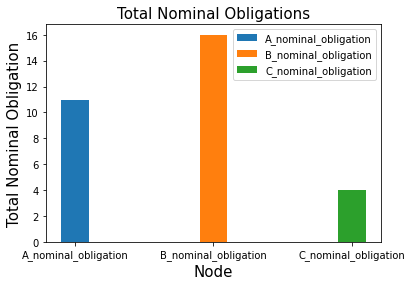


--------------------------------------------------------



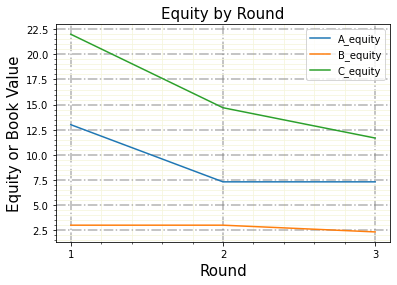


--------------------------------------------------------



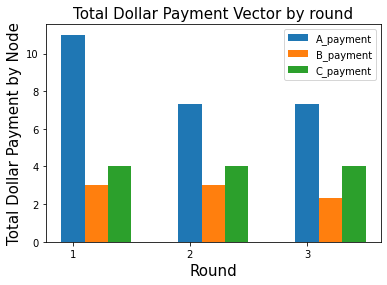


--------------------------------------------------------



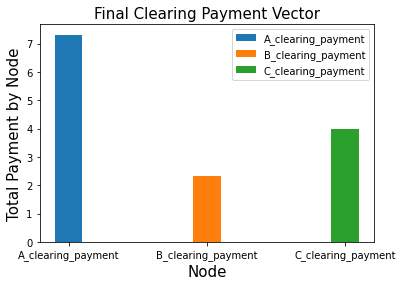


--------------------------------------------------------



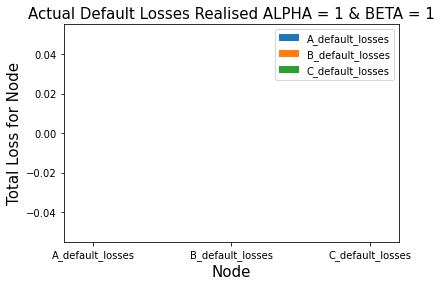

ALPHA and BETA are the fraction of exogenous assets (outside financial network) and endogenous assets (inside financial network i.e. interbank obligations) that are realised on liquidation in the event of default. The two fractions may conceivably be different; we would typically expect that ALPHA would be low,because the bank would be having to sell off its loan portfolio, probably at a knock-down price or fire sale. In contrast, BETA might be much closer to 1, because an obligation from a solvent bank would probably be paid in full (though perhaps with some negotiated discount to compensate for the inconvenience of early repayment).

--------------------------------------------------------



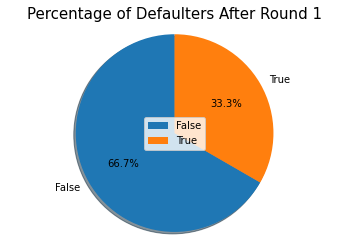

Node A has NOT defaulted in round 1
Node B has defaulted in round 1
Node C has NOT defaulted in round 1


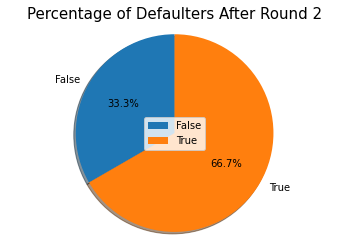

Node A has defaulted in round 2
Node B has defaulted in round 2
Node C has NOT defaulted in round 2


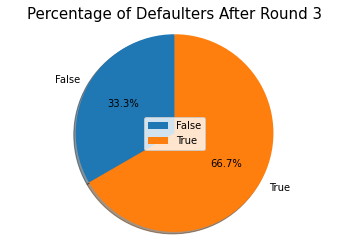

Node A has defaulted in round 3
Node B has defaulted in round 3
Node C has NOT defaulted in round 3

--------------------------------------------------------



In [44]:
import numpy as np
import matplotlib.pyplot as plt

######### SETUP BAR and LINE GRAPH DATASTRUCTURES ######### 

GRAPH_DICT = {}
EQUITY_LABELS = []
NOMINAL_OBLIGATION_LABELS = []
PAYMENT_LABELS = []
CLEARING_PAYMENT_LABELS = []
DEFAULT_LOSSES_LABELS = []

WIDTH = 0.2       # the width of the bars


# setup keys for each node and each value of interest
for node in AGENT_LABELS:
    node_equity_key = node + "_equity"
    node_payment_vector_key = node + "_payment"
    node_nominal_obligation_key = node + "_nominal_obligation"
    node_clearing_payment_key = node + "_clearing_payment"
    node_default_loss_key = node + "_default_losses"

    GRAPH_DICT[node_equity_key] = []
    GRAPH_DICT[node_payment_vector_key] = []
    GRAPH_DICT[node_nominal_obligation_key] = []
    GRAPH_DICT[node_clearing_payment_key] = []
    GRAPH_DICT[node_default_loss_key] = []

graph_dict_keys = GRAPH_DICT.keys()
print("\n--------------------------------------------------------\n")

print(SCENARIO)

print("\n--------------------------------------------------------\n")

######### PLOT BAR CHART OF TOTAL NOMINAL OBLIGATION FOR EACH NODE ######### 

# prepare total nominal obligation for graphing
total_obligation_vector = return_total_obligation_vector() #[2,3,5]

# print(total_obligation_vector)
for index, value in enumerate(total_obligation_vector):
    node_key = AGENT_LABELS[index] + "_nominal_obligation" #e.g. index 0 is A_nominal_obligation, index 1 is B_nominal_obligation
    NOMINAL_OBLIGATION_LABELS.append(node_key)
    GRAPH_DICT[node_key].append(value)

# plot total nominal obligation
total_nominal_obligation_legend = []
for graph_key in graph_dict_keys:
    if graph_key in NOMINAL_OBLIGATION_LABELS:
        nominal_obligation_values_for_node = GRAPH_DICT[graph_key]
        bar2, = plt.bar(graph_key, nominal_obligation_values_for_node, width=WIDTH, label=graph_key)
        total_nominal_obligation_legend.append(bar2)
        
# display legend
plt.legend()

plt.xlabel('Node', fontsize=15)
plt.ylabel('Total Nominal Obligation', fontsize=15)
plt.title('Total Nominal Obligations', fontsize=15)
plt.show()

print("\n--------------------------------------------------------\n")

######### PLOT LINE CHART AND BAR CHART OF EQUITY CHANGES BY ROUND ######### 

# prepare equity vector for graphing
for round in EQUITY_VECTOR:
    equity_vector_for_round = return_equity_for_round(round) #[2,3,5]
    # print("equity_vector_for_round", equity_vector_for_round)
    for index, value in enumerate(equity_vector_for_round):
        node_key = AGENT_LABELS[index] + "_equity" #e.g. index 0 is A_equity, index 1 is B_equity
        EQUITY_LABELS.append(node_key)
        GRAPH_DICT[node_key].append(value)

# plot equity
equity_legend = []
equity_round_index = 0
for graph_key in graph_dict_keys:
    if graph_key in EQUITY_LABELS:
         # set width shift for side by side bar chart to avoid bar chart stcking
        width_shift = WIDTH * equity_round_index
        # print("width_shift ", width_shift)
        equity_round_index = equity_round_index + 1
        
        equity_values_for_node = GRAPH_DICT[graph_key]
        #print("equity_values_for_node", graph_key, equity_values_for_node)
        
        length_equity_values = len(equity_values_for_node)
        #print("length_equity_values", length_equity_values)    
        
        equity_rounds = list(range(1,length_equity_values + 1))
        #print("equity_rounds", equity_rounds)    
        width_adjusted_x_values = [x + width_shift for x in equity_rounds]
        if length_equity_values > 1:
            line1, = plt.plot(equity_rounds, equity_values_for_node, label=graph_key)
            equity_legend.append(line1)
        else:
            plt.bar(width_adjusted_x_values, equity_values_for_node, width=WIDTH, label=graph_key)

# if we are showing a line chart
if length_equity_values > 1:
        
    # position legend
    plt.legend(handles=equity_legend, loc='upper right')

    # major grid lines
    plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)

    # minor grid lines
    plt.minorticks_on()

    plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)

# use rounds as labels for x-axis
plt.xticks(equity_rounds)

# display legend
plt.legend()

plt.xlabel('Round', fontsize=15)
plt.ylabel('Equity or Book Value', fontsize=15)
plt.title('Equity by Round', fontsize=15)
plt.show()

print("\n--------------------------------------------------------\n")

######### PLOT BAR CHART OF TOTAL DOLLAR PAYMENT VECTOR FOR EACH NODE BY ROUND ######### 

# prepare dollar payment vector for graphing
# iterate over rounds (i.e. keys) in TOTAL_DOLLAR_PAYMENT_VECTOR which is a dict
for round in TOTAL_DOLLAR_PAYMENT_VECTOR:
    # return total dollar payment vector for all nodes for a given round e.g. [2,3,5]
    total_dollar_payment_for_round = return_total_dollar_payment_for_round(round) 
    
    # iterate over total dollar payment vector for a round, return index and each individual value
    for index, value in enumerate(total_dollar_payment_for_round):
        # assign a node key based on index e.g. index 0 is A_payment, index 1 is B_payment
        node_key = AGENT_LABELS[index] + "_payment" 
        
        # update list of keys for total dollar payments i.e. A_payment, B_payment etc
        PAYMENT_LABELS.append(node_key)
        
        # update list of values for node e.g. list of dollar payments for node A identified by A_payment 
        GRAPH_DICT[node_key].append(value)
        
# plot dollar payment vector
dollar_payment_legend = []
dollar_payment_round_index = 0
for graph_key in graph_dict_keys:
    # check for payment labels e.g. A_payment, B_payment etc
    if graph_key in PAYMENT_LABELS:
        # return list of payments made by node
        dollar_payment_values_for_node = GRAPH_DICT[graph_key]
        # print(graph_key)
        # print(dollar_payment_values_for_node)
                
        # set width shift for side by side bar chart to avoid bar chart stcking
        width_shift = WIDTH * dollar_payment_round_index
        # print("width_shift ", width_shift)
        dollar_payment_round_index = dollar_payment_round_index + 1
        
        # return count of payments made by node
        length_dollar_payment_values = len(dollar_payment_values_for_node)
        
        # return corresponding rounds made by node, starting from 1
        dollar_payment_rounds = list(range(1,length_dollar_payment_values + 1))
        # print("dollar_payment_rounds ", dollar_payment_rounds)
        width_adjusted_x_values = [x + width_shift for x in dollar_payment_rounds]
        # print("width_adjusted_x_values ", width_adjusted_x_values)
        
        # for each payment made by the node, add a bar to the graph
        plt.bar(width_adjusted_x_values, dollar_payment_values_for_node, width=WIDTH, label=graph_key)
        #dollar_payment_legend.append(bar1)

# use rounds as labels for x-axis
plt.xticks(dollar_payment_rounds)

# display legend
plt.legend()

plt.xlabel('Round', fontsize=15)
plt.ylabel('Total Dollar Payment by Node', fontsize=15)
plt.title('Total Dollar Payment Vector by round', fontsize=15)
plt.show()

print("\n--------------------------------------------------------\n")


######### PLOT BAR CHART OF FINAL CLEARING PAYMENT VECTOR ######### 

# prepare clearing payment vector for graphing
# print(CLEARING_PAYMENT_VECTOR)
for index, value in enumerate(CLEARING_PAYMENT_VECTOR):
    node_key = AGENT_LABELS[index] + "_clearing_payment"
    CLEARING_PAYMENT_LABELS.append(node_key)
    GRAPH_DICT[node_key].append(value)

# plot clearing payment vector
clearing_payment_legend = []
for graph_key in graph_dict_keys:
    if graph_key in CLEARING_PAYMENT_LABELS:
        clearing_payment_values_for_node = GRAPH_DICT[graph_key]
        bar3, = plt.bar(graph_key, clearing_payment_values_for_node, width=WIDTH, label=graph_key)
        clearing_payment_legend.append(bar3)

# display legend
plt.legend()

plt.xlabel('Node', fontsize=15)
plt.ylabel('Total Payment by Node', fontsize=15)
plt.title('Final Clearing Payment Vector', fontsize=15)
plt.show()

print("\n--------------------------------------------------------\n")


######### PLOT BAR CHART OF DEFAULT LOSSES ######### 

# prepare default losses vector for graphing
# print(DEFAULT_LOSSES_VECTOR)
for index, value in enumerate(DEFAULT_LOSSES_VECTOR):
    node_key = AGENT_LABELS[index] + "_default_losses"
    DEFAULT_LOSSES_LABELS.append(node_key)
    GRAPH_DICT[node_key].append(value)

# plot default loss vector
default_losses_legend = []
for graph_key in graph_dict_keys:
    if graph_key in DEFAULT_LOSSES_LABELS:
        default_loss_for_node = GRAPH_DICT[graph_key]
        bar4, = plt.bar(graph_key, default_loss_for_node, width=WIDTH, label=graph_key)
        default_losses_legend.append(bar4)

# display legend
plt.legend()

plt.xlabel('Node', fontsize=15)
plt.ylabel('Total Loss for Node', fontsize=15)
plt.title('Actual Default Losses Realised ALPHA = %s & BETA = %s' % (ALPHA, BETA), fontsize=15)
plt.show()
print("ALPHA and BETA are the fraction of exogenous assets (outside financial network) and endogenous assets " \
      "(inside financial network i.e. interbank obligations) that are realised on liquidation in the event of "\
      "default. The two fractions may conceivably be different; we would typically expect that ALPHA would be "\
      "low,because the bank would be having to sell off its loan portfolio, probably at a knock-down price or "\
      "fire sale. In contrast, BETA might be much closer to 1, because an obligation from a solvent bank would "\
      "probably be paid in full (though perhaps with some negotiated discount to compensate for the " \
      "inconvenience of early repayment).")

print("\n--------------------------------------------------------\n")

######### PLOT PIE CHARTS OF DEFAULTERS PER ROUND ######### 

# prepare defaulters vector for graphing
# iterate over rounds (i.e. keys) in DEFAULTERS_VECTOR which is a dict
for round in DEFAULTERS_VECTOR:
    # return default vector for all nodes for a given round e.g. [False, False, True] means C defaulted
    defaulters_vector_for_round = return_defaulters_vector_for_round(round) 
    #print("defaulters_vector_for_round ", defaulters_vector_for_round)
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = list(set(defaulters_vector_for_round))
    labels.sort()
    #print("labels " , labels)
    sizes = []
    false_count = defaulters_vector_for_round.count(False)
    true_count = defaulters_vector_for_round.count(True)
    total_count = true_count + false_count # this should add up to the number of nodes in system
    false_size = (false_count / total_count) * 100
    true_size = (true_count / total_count) * 100
    if false_size > 0:
        sizes.append(false_size)
    if true_size > 0:
        sizes.append(true_size)
    explode = None  # do not explode any slice
    #explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'True')

    fig1, ax1 = plt.subplots()
    #fig1, ax1 = plt.subplots(ncols=2, figsize=(10,4))

    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plot_title = 'Percentage of Defaulters After Round %s' % str(round + 1)
    plt.title(plot_title, fontsize=15)
    
    plt.legend(loc="center")

    plt.show()
    return_defaulting_nodes(round)

print("\n--------------------------------------------------------\n")

